# Groupi code

* **Run in Colab**
* run the first cell, and the precessing will shotdown, then run the code from the second cell



In [1]:
## Environment
!pip install swig
!pip install wrds
!pip install pyportfolioopt
## install finrl library
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.8 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.23
    Uninstalling SQLAlchemy-2.0.23:
      Successfully uninstalled SQLAlchemy-2.0.23
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.50 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.1 MB/s eta 0:00:00
⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:09
🔁 Restarting kernel...
Select

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

/usr/local/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



In [3]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [4]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-12-01'

In [5]:
my_custom_tickers = ["AAPL", "GOOGL", "AMZN", "TSLA", "MSFT"]
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = my_custom_tickers).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (17388, 8)


In [6]:
# print(config_tickers.DOW_30_TICKER)
print(my_custom_tickers)

['AAPL', 'GOOGL', 'AMZN', 'TSLA', 'MSFT']


In [7]:
df.shape

(17388, 8)

In [8]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,7.622500,7.660714,7.585000,6.478999,493729600,AAPL,0
1,2010-01-04,6.812500,6.830500,6.657000,6.695000,151998000,AMZN,0
2,2010-01-04,15.689439,15.753504,15.621622,15.684434,78169752,GOOGL,0
3,2010-01-04,30.620001,31.100000,30.590000,23.474924,38409100,MSFT,0
4,2010-01-05,7.664286,7.699643,7.616071,6.490200,601904800,AAPL,1


In [9]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (3501, 8)
Successfully added vix
Successfully added turbulence index


In [10]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [11]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,AAPL,7.622500,7.660714,7.585000,6.478999,493729600.0,0.0,0.000000,6.500440,6.468759,100.000000,66.666667,100.000000,6.478999,6.478999,20.040001,0.0
1,2010-01-04,AMZN,6.812500,6.830500,6.657000,6.695000,151998000.0,0.0,0.000000,6.500440,6.468759,100.000000,66.666667,100.000000,6.695000,6.695000,20.040001,0.0
2,2010-01-04,GOOGL,15.689439,15.753504,15.621622,15.684434,78169752.0,0.0,0.000000,6.500440,6.468759,100.000000,66.666667,100.000000,15.684434,15.684434,20.040001,0.0
3,2010-01-04,MSFT,30.620001,31.100000,30.590000,23.474924,38409100.0,0.0,0.000000,6.500440,6.468759,100.000000,66.666667,100.000000,23.474924,23.474924,20.040001,0.0
4,2010-01-05,AAPL,7.664286,7.699643,7.616071,6.490200,601904800.0,1.0,0.000251,6.500440,6.468759,100.000000,66.666667,100.000000,6.484599,6.484599,19.350000,0.0
5,2010-01-05,AMZN,6.671500,6.774000,6.590500,6.734500,177038000.0,1.0,0.000886,6.770611,6.658889,100.000000,-66.666667,100.000000,6.714750,6.714750,19.350000,0.0
6,2010-01-05,GOOGL,15.695195,15.711712,15.554054,15.615365,120067812.0,1.0,-0.001550,15.747578,15.552221,0.000000,-66.666667,100.000000,15.649899,15.649899,19.350000,0.0
7,2010-01-05,MSFT,30.850000,31.100000,30.639999,23.482506,49749600.0,1.0,0.000170,23.489437,23.467993,100.000000,66.666667,100.000000,23.478715,23.478715,19.350000,0.0
8,2010-01-06,AAPL,7.656429,7.686786,7.526786,6.386965,552160000.0,2.0,-0.002881,6.565348,6.338761,9.492655,-100.000000,42.057878,6.452054,6.452054,19.160000,0.0
9,2010-01-06,AMZN,6.730000,6.736500,6.582500,6.612500,143576000.0,2.0,-0.002654,6.805167,6.556167,23.837198,-100.000000,100.000000,6.680667,6.680667,19.160000,0.0


In [12]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

In [13]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

11828
2176


In [14]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2955,2021-09-29,MSFT,285.100006,286.769989,283.010010,278.381348,26353700.0,2.0,-1.289764,302.771292,280.696464,46.096637,-257.436203,37.416130,292.687962,285.825230,22.559999,1.994342
2956,2021-09-30,AAPL,143.660004,144.380005,141.279999,139.697647,89056700.0,3.0,-1.623113,155.379425,137.039821,45.507952,-134.683033,34.591874,146.710491,145.684658,23.139999,0.507033
2956,2021-09-30,AMZN,165.800003,166.392502,163.699493,164.251999,56848000.0,3.0,-1.081312,178.384997,164.074204,43.656332,-81.690206,34.267697,169.645601,172.062409,23.139999,0.507033
2956,2021-09-30,GOOGL,134.261505,135.542496,133.556000,133.675995,37996000.0,3.0,-0.802626,147.394094,134.558908,46.666809,-191.614920,33.114694,141.198984,136.805125,23.139999,0.507033
2956,2021-09-30,MSFT,285.709991,287.829987,281.619995,276.342529,32343600.0,3.0,-2.148349,303.568457,277.947693,44.758891,-242.878356,39.799221,292.400105,285.866478,23.139999,0.507033


In [15]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-10-01,AAPL,141.899994,142.919998,139.110001,140.832962,94639600.0,4.0,-1.696606,154.755083,136.578169,46.927701,-142.214135,41.749873,146.577209,145.678475,21.100000,6.473126
0,2021-10-01,AMZN,164.450500,165.458496,162.796997,164.162994,56712000.0,4.0,-1.350730,178.531089,163.028811,43.571885,-98.534373,36.982555,169.804784,171.688951,21.100000,6.473126
0,2021-10-01,GOOGL,134.447495,136.910507,134.072998,136.542999,35360000.0,4.0,-0.913859,147.251483,134.027118,50.568036,-149.367409,23.408883,141.227751,136.996775,21.100000,6.473126
0,2021-10-01,MSFT,282.119995,289.980011,281.290009,283.380463,30086300.0,4.0,-2.235117,303.204253,277.130736,49.946085,-174.702255,31.518775,292.149495,286.065953,21.100000,6.473126
1,2021-10-04,AAPL,141.759995,142.210007,138.270004,137.367706,98322000.0,0.0,-2.011282,154.158470,135.678093,43.360595,-158.802014,44.273379,146.279384,145.583815,22.959999,3.447950


In [16]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [17]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 4, State Space: 41


In [18]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [19]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [20]:
agent = DRLAgent(env = env_train)

if_using_ddpg = True



In [21]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
Logging to results/ddpg


In [22]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=80000) if if_using_ddpg else None

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 152        |
|    time_elapsed    | 77         |
|    total_timesteps | 11828      |
| train/             |            |
|    actor_loss      | 1.83e+03   |
|    critic_loss     | 2.62e+03   |
|    learning_rate   | 0.001      |
|    n_updates       | 8871       |
|    reward          | -11.575538 |
-----------------------------------
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 137        |
|    time_elapsed    | 171        |
|    total_timesteps | 23656      |
| train/             |            |
|    actor_loss      | 1.01e+03   |
|    critic_loss     | 387        |
|    learning_rate   | 0.001      |
|    n_updates       | 20699      |
|    reward          | -11.575538 |
-----------------------------------
day: 2956, episode: 10
begin_total_asset: 1000000.00
end_total_a

In [23]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [24]:
insample_risk_indicator.vix.describe()

count    2957.000000
mean       18.105293
std         7.272476
min         9.140000
25%        13.370000
50%        16.209999
75%        20.629999
max        82.690002
Name: vix, dtype: float64

In [25]:
insample_risk_indicator.vix.quantile(0.996)

57.212001831054636

In [26]:
insample_risk_indicator.turbulence.describe()

count    2957.000000
mean        4.091170
std        10.903797
min         0.000000
25%         0.746151
50%         1.762086
75%         3.798041
max       294.688105
Name: turbulence, dtype: float64

In [27]:
insample_risk_indicator.turbulence.quantile(0.996)

81.51752932939482

In [28]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [29]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-10-01,AAPL,141.899994,142.919998,139.110001,140.832962,94639600.0,4.0,-1.696606,154.755083,136.578169,46.927701,-142.214135,41.749873,146.577209,145.678475,21.100000,6.473126
0,2021-10-01,AMZN,164.450500,165.458496,162.796997,164.162994,56712000.0,4.0,-1.350730,178.531089,163.028811,43.571885,-98.534373,36.982555,169.804784,171.688951,21.100000,6.473126
0,2021-10-01,GOOGL,134.447495,136.910507,134.072998,136.542999,35360000.0,4.0,-0.913859,147.251483,134.027118,50.568036,-149.367409,23.408883,141.227751,136.996775,21.100000,6.473126
0,2021-10-01,MSFT,282.119995,289.980011,281.290009,283.380463,30086300.0,4.0,-2.235117,303.204253,277.130736,49.946085,-174.702255,31.518775,292.149495,286.065953,21.100000,6.473126
1,2021-10-04,AAPL,141.759995,142.210007,138.270004,137.367706,98322000.0,0.0,-2.011282,154.158470,135.678093,43.360595,-158.802014,44.273379,146.279384,145.583815,22.959999,3.447950


In [30]:
# trained_moedl = trained_a2c
# df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
#     model=trained_moedl,
#     environment = e_trade_gym)

In [31]:
trained_moedl = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [32]:
print(df_account_value_ddpg, df_actions_ddpg)

           date  account_value
0    2021-10-01   1.000000e+06
1    2021-10-04   9.991556e+05
2    2021-10-05   9.998271e+05
3    2021-10-06   1.000676e+06
4    2021-10-07   1.001963e+06
..          ...            ...
539  2023-11-22   1.073398e+06
540  2023-11-24   1.069265e+06
541  2023-11-27   1.071866e+06
542  2023-11-28   1.071550e+06
543  2023-11-29   1.066027e+06

[544 rows x 2 columns]             AAPL  AMZN  GOOGL  MSFT
date                               
2021-10-01   100   100      0     0
2021-10-04   100   100      0     0
2021-10-05   100   100      0     0
2021-10-06   100   100      0     0
2021-10-07   100   100      0     0
...          ...   ...    ...   ...
2023-11-21     0     0      0     0
2023-11-22     0     0      0     0
2023-11-24     0     0      0     0
2023-11-27     0     0      0     0
2023-11-28     0     0      0     0

[543 rows x 4 columns]


In [33]:
# trained_moedl = trained_ppo
# df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
#     model=trained_moedl,
#     environment = e_trade_gym)

In [34]:
# trained_moedl = trained_td3
# df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
#     model=trained_moedl,
#     environment = e_trade_gym)

In [35]:
# trained_moedl = trained_sac
# df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
#     model=trained_moedl,
#     environment = e_trade_gym)

In [36]:
df_account_value_ddpg.shape

(544, 2)

In [37]:
# df_dji = YahooDownloader(
#     start_date=TRADE_START_DATE, end_date=TRADE_END_DATE, ticker_list=["dji"]
# ).fetch_data()
# df_dji = df_dji[["date", "close"]]
# fst_day = df_dji["close"][0]
# dji = pd.merge(
#     df_dji["date"],
#     df_dji["close"].div(fst_day).mul(1000000),
#     how="outer",
#     left_index=True,
#     right_index=True,
# ).set_index("date")

In [38]:
# # df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
# df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
# # df_account_value_a2c.to_csv("df_account_value_a2c.csv")
# #baseline stats

# print("==============Get Baseline Stats===========")
# df_dji_ = get_baseline(
#         ticker="^DJI",
#         start = TRADE_START_DATE,
#         end = TRADE_END_DATE)
# stats = backtest_stats(df_dji_, value_col_name = 'close')
# df_dji = pd.DataFrame()
# df_dji['date'] = df_account_value_ddpg['date']
# df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]


In [39]:
# ## ddpg stat report
# print("==============Get Backtest Results===========")
# now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

# perf_stats_all = backtest_stats(account_value=df_account_value_ddpg)
# perf_stats_all = pd.DataFrame(perf_stats_all)
# perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

In [40]:
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)

df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_ddpg['date']
df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

print("==============Get Baseline Stats ddpg===========")
stats_dji = backtest_stats(df_dji_, value_col_name = 'close')
stats_ddpg = backtest_stats(df_account_value_ddpg, value_col_name = 'account_value')

import pandas as pd

# 假设 stats_dji 和 stats_ddpg 是包含统计信息的 DataFrame

# 写入 stats_dji 到 CSV 文件
stats_dji.to_csv('stats_dji.csv', index=False)

# 写入 stats_ddpg 到 CSV 文件
stats_ddpg.to_csv('stats_ddpg.csv', index=False)


==============Get Baseline Stats===========
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (545, 8)
==============Get Baseline Stats ddpg===========
Annual return          0.021610
Cumulative returns     0.047323
Annual volatility      0.160609
Sharpe ratio           0.213591
Calmar ratio           0.098491
Stability              0.009038
Max drawdown          -0.219408
Omega ratio            1.036754
Sortino ratio          0.302427
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.012362
Daily value at risk   -0.020099
dtype: float64
Annual return          0.030062
Cumulative returns     0.066027
Annual volatility      0.308910
Sharpe ratio           0.250299
Calmar ratio           0.073338
Stability              0.021319
Max drawdown          -0.409907
Omega ratio            1.043781
Sortino ratio          0.356370
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.

                    ddpg           dji
date                                  
2021-10-01  1.000000e+06  1.000000e+06
2021-10-04  9.991556e+05  9.905746e+05
2021-10-05  9.998271e+05  9.996566e+05
2021-10-06  1.000676e+06  1.002637e+06
2021-10-07  1.001963e+06  1.012483e+06
...                  ...           ...
2023-11-22  1.073398e+06  1.027576e+06
2023-11-24  1.069265e+06  1.030987e+06
2023-11-27  1.071866e+06  1.029336e+06
2023-11-28  1.071550e+06  1.031769e+06
2023-11-29  1.066027e+06  1.032161e+06

[544 rows x 2 columns]


<Axes: xlabel='date'>

<Figure size 1500x500 with 0 Axes>

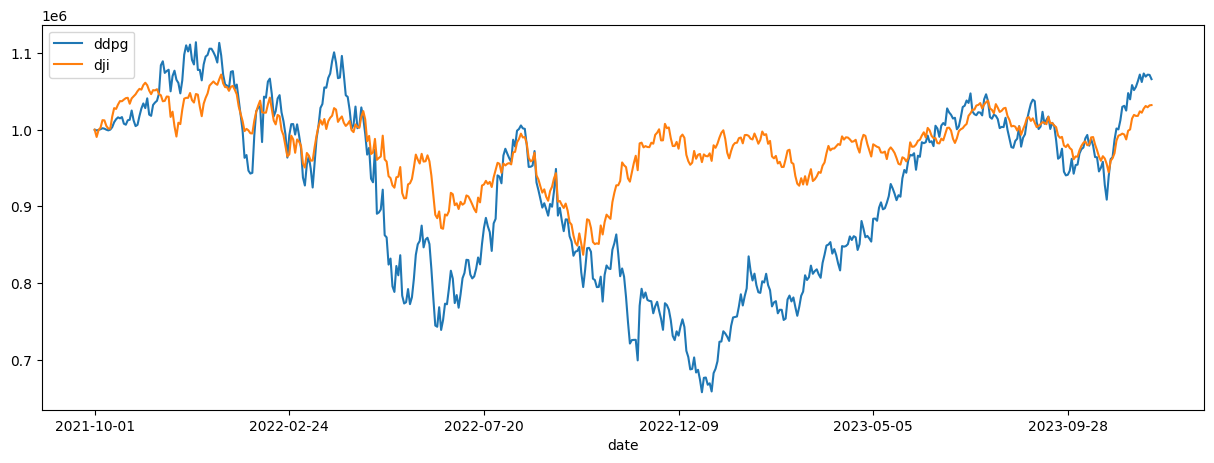

In [41]:



# df_result_a2c = (
#     df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
#     if if_using_a2c
#     else None
# )
df_result_ddpg = (
    df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
    if if_using_ddpg
    else None
)
# df_result_ppo = (
#     df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
#     if if_using_ppo
#     else None
# )
# df_result_td3 = (
#     df_account_value_td3.set_index(df_account_value_td3.columns[0])
#     if if_using_td3
#     else None
# )
# df_result_sac = (
#     df_account_value_sac.set_index(df_account_value_sac.columns[0])
#     if if_using_sac
#     else None
# )

result = pd.DataFrame(
    {
        # "a2c": df_result_a2c["account_value"] if if_using_a2c else None,
        "ddpg": df_result_ddpg["account_value"] if if_using_ddpg else None,
        # "ppo": df_result_ppo["account_value"] if if_using_ppo else None,
        # "td3": df_result_td3["account_value"] if if_using_td3 else None,
        # "sac": df_result_sac["account_value"] if if_using_sac else None,
        # "mvo": MVO_result["Mean Var"],
        "dji": df_dji["account_value"],
    }
)

print(result)

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()
# plt.show()

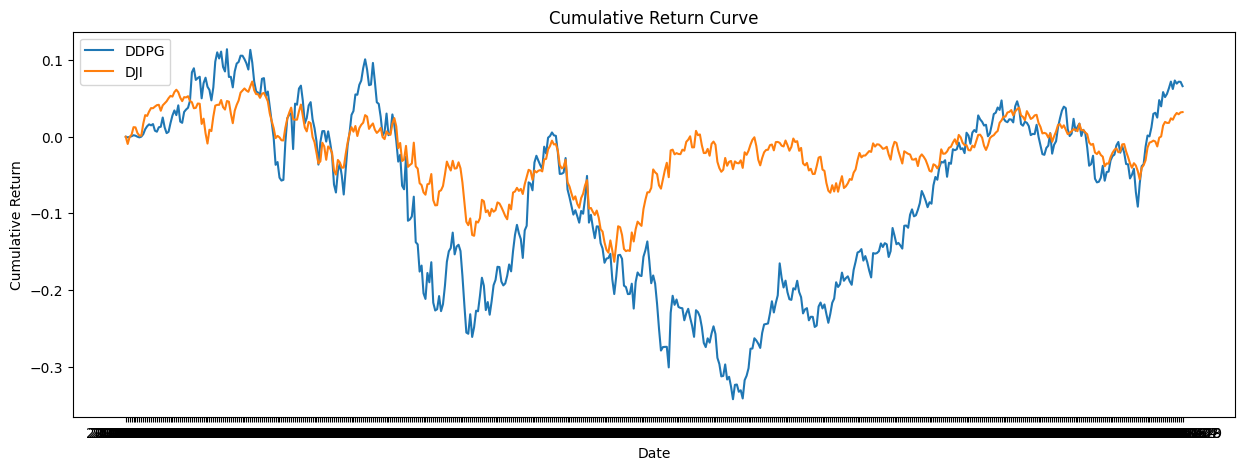

In [42]:
# 导入必要的库
import pandas as pd
import matplotlib.pyplot as plt

# 读取您的数据
df = result

# 计算累积回报率
df["cum_ddpg"] = df["ddpg"] / df["ddpg"].iloc[0] - 1
df["cum_dji"] = df["dji"] / df["dji"].iloc[0] - 1

# 绘制累积回报曲线
plt.figure(figsize=(15,5))
plt.plot(df["cum_ddpg"], label="DDPG")
plt.plot(df["cum_dji"], label="DJI")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Cumulative Return Curve")
plt.legend()
# plt.grid()
plt.show()


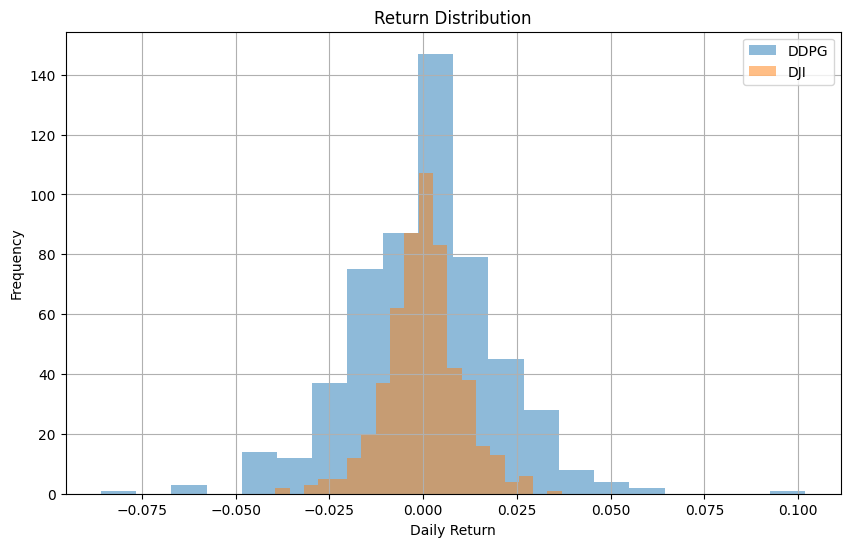

In [43]:
# 计算日收益率
df["ret_ddpg"] = df["ddpg"].pct_change()
df["ret_dji"] = df["dji"].pct_change()

# 绘制收益率分布
plt.figure(figsize=(10, 6))
plt.hist(df["ret_ddpg"], bins=20, alpha=0.5, label="DDPG")
plt.hist(df["ret_dji"], bins=20, alpha=0.5, label="DJI")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.title("Return Distribution")
plt.legend()
plt.grid()
plt.show()

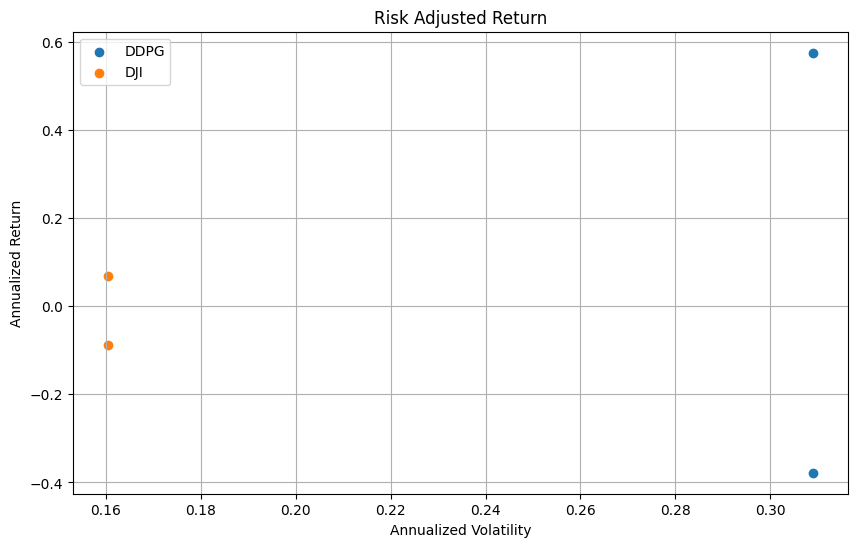

In [44]:
# 转换您的数据的索引为日期时间格式
df.index = pd.to_datetime(df.index)

# 计算日收益率
df["ret_ddpg"] = df["ddpg"].pct_change()
df["ret_dji"] = df["dji"].pct_change()

# 计算年化收益率和波动率
df_annual = df.resample("Y").last()
df_annual["ret_ddpg"] = df_annual["ddpg"] / df_annual["ddpg"].shift(1) - 1
df_annual["ret_dji"] = df_annual["dji"] / df_annual["dji"].shift(1) - 1
df_annual["vol_ddpg"] = df["ret_ddpg"].std() * np.sqrt(252)
df_annual["vol_dji"] = df["ret_dji"].std() * np.sqrt(252)

# 计算夏普比率
df_annual["sharpe_ddpg"] = (df_annual["ret_ddpg"] - 0.02) / df_annual["vol_ddpg"]
df_annual["sharpe_dji"] = (df_annual["ret_dji"] - 0.02) / df_annual["vol_dji"]

# 绘制风险调整收益率
plt.figure(figsize=(10, 6))
plt.scatter(df_annual["vol_ddpg"], df_annual["ret_ddpg"], label="DDPG")
plt.scatter(df_annual["vol_dji"], df_annual["ret_dji"], label="DJI")
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Risk Adjusted Return")
plt.legend()
plt.grid()
plt.show()

<ipython-input-45-947794604a50>:23: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  sns.boxplot(data=[df["ret_ddpg"], df_weekly["ret_ddpg"], df_monthly["ret_ddpg"], df_annual["ret_ddpg"]],


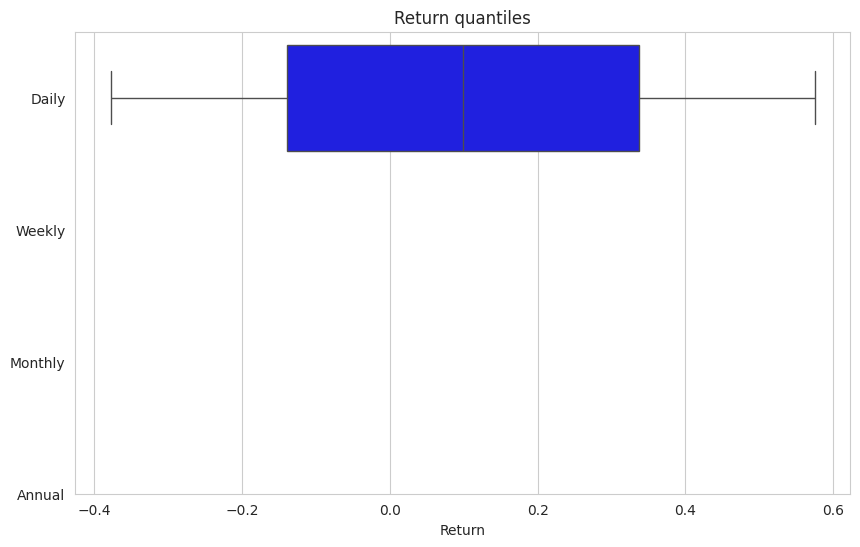

In [45]:
# 计算周收益率
df_weekly = df.resample("W").last()
df_weekly["ret_ddpg"] = df_weekly["ddpg"] / df_weekly["ddpg"].shift(1) - 1

# 计算月收益率
df_monthly = df.resample("M").last()
df_monthly["ret_ddpg"] = df_monthly["ddpg"] / df_monthly["ddpg"].shift(1) - 1

# 计算年收益率
df_annual = df.resample("Y").last()
df_annual["ret_ddpg"] = df_annual["ddpg"] / df_annual["ddpg"].shift(1) - 1


# 导入必要的库
import matplotlib.pyplot as plt
import seaborn as sns

# 设置风格和大小
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# 绘制水平箱线图
sns.boxplot(data=[df["ret_ddpg"], df_weekly["ret_ddpg"], df_monthly["ret_ddpg"], df_annual["ret_ddpg"]],
            orient="h",
            palette=["blue", "green", "orange", "red"])

# 设置标题和标签
plt.title("Return quantiles")
plt.yticks([0, 1, 2, 3], ["Daily", "Weekly", "Monthly", "Annual"])
plt.xlabel("Return")
plt.show()
